# Perfect competition

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import support_functions as sf
#main model classses
from market import Market
from bank import Bank
from customer_group import Customer_group

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


# Variables

In [2]:
### Simulation settings ###
time_steps = 100

### Market setting ###
score_range = [300,850]
repay_score = 75
default_score = -150

#this correspends to selection rate(perfect competition [0,1])
plane_range = [0, 1]
plane_slice_step = 0.01

#initial interest rate setting
initial_interest_rate_range = [0.15, 0.1]

#demand and supply interest rate boundaries
max_interest_rate_range = [0.3, 0.2]
min_interest_rate_range = [0.03, 0.02]

#policy
selected_policy = 2  #0=MU, 1=DP , 2=EO 
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

### Bank setting ###
bank_line_style = ['-.']
bank_color = ['blue']
#number of banks in the market
N_banks = 21

#bank score distribution shift(same number of shifts as banks)
score_shifts = [0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# profit and impact for banks (same for every bank, but different profit and impact can be set for each bank and model different revenue/cost "function")
utility_repaid = 1
utility_default = -4

### Customer groups setting ###
#use unique names
group_names = ["White","Black"]
group_colors = ['grey', 'black']
group_line_style = ['-',':']

#maximal interest rate which are customers willing to accept
interest_rate_limit = np.inf

#estimated number of customers in each group
white_totals = 8800
black_totals = 1200
loan_demand = 0.1

error_rate = 0.5
score_error = 150

# Prepare initial data

In [3]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals (too many people)
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

#demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customer_scores = sf.get_ref_customers(customer_totals, pis_total, scores_list)

Reference group totals: [8800 1200]
Calculated group totals: [8805 1193]
Group size ratio: [ 0.88067614  0.11932386]


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# Create Model

In [4]:
#create market
market = Market(policy_names[selected_policy], policy_colors[selected_policy], score_range = score_range ,repay_score = repay_score, default_score = default_score, max_interest_rate_range = max_interest_rate_range, min_interest_rate_range = min_interest_rate_range, plane_range= plane_range, plane_slice_step = plane_slice_step)

banks= []
for i in range(0,N_banks):
    banks.append(Bank("bank_%02d" % i, bank_color[0],bank_line_style[0], initial_interest_rate_range, market, score_shift=score_shifts[i], utility_repaid=utility_repaid, utility_default = utility_default))

white_group = Customer_group(group_names[0], group_colors[0], group_line_style[0], customer_totals[0], ref_customer_scores[0], loan_demand, 0, 0, market, repays, interest_rate_limit=interest_rate_limit)
black_group = Customer_group(group_names[1], group_colors[1], group_line_style[1], customer_totals[1], ref_customer_scores[1], loan_demand, error_rate, score_error, market, repays, interest_rate_limit=interest_rate_limit)
groups = [white_group, black_group]

### Init model values

In [5]:
for bank in banks:
    market.max_irates[bank.name] = []
    market.min_irates[bank.name] = []
    market.max_irates[bank.name].append(bank.interest_rate_range[0])
    market.min_irates[bank.name].append(bank.interest_rate_range[1])
    
    for group in groups:
        bank.N_loan_curves[group.name] = []
        bank.total_utility_curves[group.name] = []

group_mean_score_change_curve = {}
total_loans = {}
total_utility = {}
for group in groups:      
    group_mean_score_change_curve[group.name] = [0]
    market.loans[group.name] = [0]
    market.utility[group.name] = [0]
    total_loans[group.name] = 0
    total_utility[group.name] = 0

# Next step

In [6]:
for time in range(0, time_steps):
    print("############### STEP "+ str(market.step) + " -> " + str(market.step+1) + " ##################" )
    utilities = {}
    utility_curves = {}
    N_loans = {}
    step_loans = 0
    step_customers = 0
    
    ### Before ###            
    selection_rates, max_util = market.get_selection_rate(banks, groups)
    for bank in banks:
        bank.set_selection_rate(selection_rates[bank.name])
        utilities[bank.name] = {}
        utility_curves[bank.name] = {}
        N_loans[bank.name] = {}

    ### During ###
    for group in groups:
        for bank in banks:
            utilities[bank.name][group.name] = 0
            utility_curves[bank.name][group.name] = []
            N_loans[bank.name][group.name] = 0
            
        #select part of customer base at random according to group loan demand
        customers = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        step_customers += len(customers) 
        #go over all selected customers in the group
        for j in customers:
            selected_bank = None
            bank_select_order = random.sample(range(0, len(banks)), len(banks))
            
            # check banks at random if they give loan to customer j
            for k in bank_select_order:
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    selected_bank = k
                    step_loans += 1
                    total_loans[group.name] += 1
                    break

            if selected_bank is not None:
                #get loan outcome and change score
                N_loans[banks[selected_bank].name][group.name] += 1 
                real_customer_score = group.real_scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_customer_score])
                group.change_score(market, j, loan_outcome)
                group.change_real_score(market, j, loan_outcome)
                
                #get bank utility
                interest_rate = banks[selected_bank].score_interest_rates[group.scores[j]]
                utility_change = banks[selected_bank].get_customer_utility(interest_rate, loan_outcome)
                utilities[banks[selected_bank].name][group.name] += utility_change
                total_utility[group.name] += utility_change
                utility_curves[banks[selected_bank].name][group.name].append(utilities[banks[selected_bank].name][group.name])
        
        for bank in banks:
            if market.step == 0:
                bank.N_loan_curves[group.name].append(N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(utilities[bank.name][group.name])
            else:
                bank.N_loan_curves[group.name].append(bank.N_loan_curves[group.name][-1] + N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(bank.total_utility_curves[group.name][-1] + utilities[bank.name][group.name])        
        group.sort_scores()
        group_mean_score_change_curve[group.name].append(group.get_mean_score_change())
        print(group.name + " group mean score: " + str(group.get_mean_score_change()))
    
    market.step += 1 
    
    ### After ###
    #adjust interest rate, in perfect competition it depends on the total number of people who got a loan.
    total_selection_rate = str(round(step_loans/step_customers,2))
    score_interest_rates = market.interest_rate_plane[total_selection_rate]
    
    for bank in banks:
        bank.change_interest_rate_range(score_interest_rates, market)
        
        market.max_irates[bank.name].append(score_interest_rates[market.score_range[0]])
        market.min_irates[bank.name].append(score_interest_rates[market.score_range[1]])
    
    for group in groups:
        market.loans[group.name].append(total_loans[group.name])
        market.utility[group.name].append(total_utility[group.name])
        print("Reference bank: " + group.name + " selection rate: " + str(banks[0].group_selection_rate[group.name]))
        
    print("Market selection rate: " + str(total_selection_rate),"Interest_rate:" + str(banks[0].interest_rate_range))
    
    market.plot_market_situation_PC(banks, groups, group_mean_score_change_curve)

############### STEP 0 -> 1 ##################
White group mean score: 4.02328222601
Black group mean score: 1.40737636211
Reference bank: White selection rate: 0.658716638274
Reference bank: Black selection rate: 0.401508801341
Market selection rate: 0.74 Interest_rate:[0.10218000000000001, 0.06812]
Loans - White: 670, Utility - White: 0.747587462687
Loans - Black: 71, Utility - Black: -0.0376197183099
Loans - Total: 741.0, Utility - Total: 0.67235168691



../market.py:354: RuntimeWarning: invalid value encountered in true_divide
  ax[2][1].plot(list(range(len(self.utility[group.name]))), np.array(self.utility[group.name])/np.array(self.loans[group.name]), color = group.color, LineStyle = group.line_style,label = "Total utility per loan "+ group.name + " group")
../market.py:365: RuntimeWarning: invalid value encountered in true_divide
  ax[2][1].plot(list(range(len(total_utility))), np.array(total_utility)/np.array(total_loans), color="red",label= "Total utility per loan")


############### STEP 1 -> 2 ##################
White group mean score: 7.79784213515
Black group mean score: 2.65213746857
Reference bank: White selection rate: 0.662578080636
Reference bank: Black selection rate: 0.372170997485
Market selection rate: 0.73 Interest_rate:[0.10485, 0.069900000000000004]
Loans - White: 1347, Utility - White: 0.71480268003
Loans - Black: 128, Utility - Black: -0.017394453125
Loans - Total: 1475.0, Utility - Total: 0.651262861017

############### STEP 2 -> 3 ##################
White group mean score: 11.626689381
Black group mean score: 2.75943000838
Reference bank: White selection rate: 0.666439522998
Reference bank: Black selection rate: 0.360435875943
Market selection rate: 0.72 Interest_rate:[0.10752, 0.071679999999999994]
Loans - White: 2008, Utility - White: 0.736812579681
Loans - Black: 189, Utility - Black: -0.174118042328
Loans - Total: 2197.0, Utility - Total: 0.658448497952

############### STEP 3 -> 4 ##################
White group mean score: 1

Loans - White: 12190, Utility - White: 0.837749830189
Loans - Black: 1101, Utility - Black: 0.169678755677
Loans - Total: 13291.0, Utility - Total: 0.782408151381

############### STEP 19 -> 20 ##################
White group mean score: 54.7559341283
Black group mean score: 24.614417435
Reference bank: White selection rate: 0.6933560477
Reference bank: Black selection rate: 0.410729253982
Market selection rate: 0.68 Interest_rate:[0.11822000000000001, 0.078810000000000005]
Loans - White: 12810, Utility - White: 0.844004453552
Loans - Black: 1157, Utility - Black: 0.196345747623
Loans - Total: 13967.0, Utility - Total: 0.790353624973

############### STEP 20 -> 21 ##################
White group mean score: 56.4068143101
Black group mean score: 24.6177703269
Reference bank: White selection rate: 0.693128904032
Reference bank: Black selection rate: 0.468566638726
Market selection rate: 0.68 Interest_rate:[0.11822000000000001, 0.078810000000000005]
Loans - White: 13439, Utility - White: 0.

############### STEP 36 -> 37 ##################
White group mean score: 73.1404883589
Black group mean score: 40.2279966471
Reference bank: White selection rate: 0.69960249858
Reference bank: Black selection rate: 0.384744341995
Market selection rate: 0.69 Interest_rate:[0.11554, 0.077030000000000001]
Loans - White: 23418, Utility - White: 0.906631743958
Loans - Black: 2041, Utility - Black: 0.388555046546
Loans - Total: 25459.0, Utility - Total: 0.86509851251

############### STEP 37 -> 38 ##################
White group mean score: 73.7000567859
Black group mean score: 40.8147527242
Reference bank: White selection rate: 0.699488926746
Reference bank: Black selection rate: 0.401508801341
Market selection rate: 0.67 Interest_rate:[0.12089, 0.080589999999999995]
Loans - White: 24033, Utility - White: 0.90994566804
Loans - Black: 2096, Utility - Black: 0.396984770992
Loans - Total: 26129.0, Utility - Total: 0.868797287305

############### STEP 38 -> 39 ##################
White group mean

Loans - White: 33932, Utility - White: 0.941069551161
Loans - Black: 2898, Utility - Black: 0.514807439614
Loans - Total: 36830.0, Utility - Total: 0.907528752919

############### STEP 54 -> 55 ##################
White group mean score: 79.3065303805
Black group mean score: 48.742665549
Reference bank: White selection rate: 0.700965360591
Reference bank: Black selection rate: 0.385582564962
Market selection rate: 0.68 Interest_rate:[0.11822000000000001, 0.078810000000000005]
Loans - White: 34549, Utility - White: 0.942030056442
Loans - Black: 2960, Utility - Black: 0.523161929054
Loans - Total: 37509.0, Utility - Total: 0.908975332054

############### STEP 55 -> 56 ##################
White group mean score: 79.4660988075
Black group mean score: 49.1659681475
Reference bank: White selection rate: 0.700738216922
Reference bank: Black selection rate: 0.393964794635
Market selection rate: 0.65 Interest_rate:[0.12623999999999999, 0.084159999999999999]
Loans - White: 35149, Utility - White: 

White group mean score: 81.197955707
Black group mean score: 52.3487007544
Reference bank: White selection rate: 0.701192504259
Reference bank: Black selection rate: 0.393964794635
Market selection rate: 0.64 Interest_rate:[0.12891, 0.085940000000000003]
Loans - White: 45071, Utility - White: 0.96204762508
Loans - Black: 3804, Utility - Black: 0.610859907992
Loans - Total: 48875.0, Utility - Total: 0.934714262915

############### STEP 72 -> 73 ##################
White group mean score: 81.2891538898
Black group mean score: 52.6705783738
Reference bank: White selection rate: 0.701419647927
Reference bank: Black selection rate: 0.39564124057
Market selection rate: 0.66 Interest_rate:[0.12356, 0.082379999999999995]
Loans - White: 45680, Utility - White: 0.963366432355
Loans - Black: 3855, Utility - Black: 0.615836264591
Loans - Total: 49535.0, Utility - Total: 0.936320327647

############### STEP 73 -> 74 ##################
White group mean score: 81.2548551959
Black group mean score: 52.

Loans - White: 55600, Utility - White: 0.975778551079
Loans - Black: 4654, Utility - Black: 0.666229546627
Loans - Total: 60254.0, Utility - Total: 0.95186908338

############### STEP 89 -> 90 ##################
White group mean score: 81.9295854628
Black group mean score: 52.9689857502
Reference bank: White selection rate: 0.701987507098
Reference bank: Black selection rate: 0.398994132439
Market selection rate: 0.68 Interest_rate:[0.11822000000000001, 0.078810000000000005]
Loans - White: 56230, Utility - White: 0.976631492441
Loans - Black: 4703, Utility - Black: 0.667347590899
Loans - Total: 60933.0, Utility - Total: 0.952759991137

############### STEP 90 -> 91 ##################
White group mean score: 81.9345826235
Black group mean score: 53.283319363
Reference bank: White selection rate: 0.701987507098
Reference bank: Black selection rate: 0.387259010897
Market selection rate: 0.7 Interest_rate:[0.11287, 0.075249999999999997]
Loans - White: 56863, Utility - White: 0.977233570511

# Playing with TC, TR, MC, MR and UC

6180
1661.43111696 1126.02142138
1142.352 3112.2144


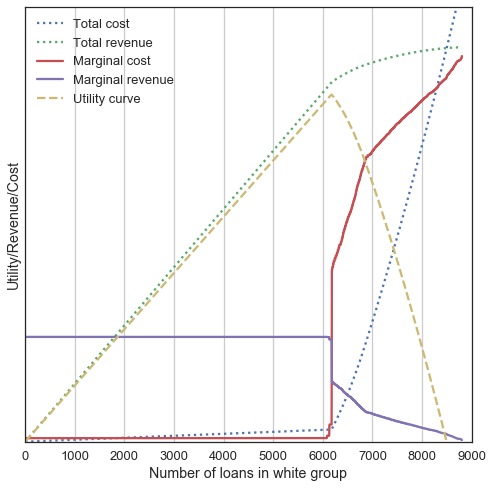

In [7]:
TC_curve = [0]
TR_curve = [0]
MC_curve = []
MR_curve = []
utility_curve = []
TC=0
TR=0
utility=0

n=0

for k in range(0, groups[n].size):
    expected_customer_score = banks[0].get_expected_customer_score(market,groups[n].scores[k])
    utility += banks[0].get_customer_evaluation_utility(expected_customer_score, groups[n])
    utility_curve.append(utility*1)
    TC += -banks[0].utility_default*(1-groups[n].score_repay_prob[expected_customer_score])
    TR += (banks[0].utility_repaid+banks[0].score_interest_rates[expected_customer_score])*groups[n].score_repay_prob[expected_customer_score]
    TC_curve.append(TC)
    TR_curve.append(TR)
    MC_curve.append((TC_curve[-1] - TC_curve[-2])*1800)
    MR_curve.append((TR_curve[-1] - TR_curve[-2])*1800)
    
plt.figure(figsize=(8,8))
plt.plot(list(range(0, len(TC_curve))),TC_curve,LineStyle=":",label="Total cost")
plt.plot(list(range(0, len(TR_curve))),TR_curve,LineStyle=":",label="Total revenue")
plt.plot(list(range(0, len(MC_curve))),MC_curve,label="Marginal cost")
plt.plot(list(range(0, len(MR_curve))),MR_curve,label="Marginal revenue")
plt.plot(list(range(0, len(utility_curve))),utility_curve,LineStyle="--",label="Utility curve")
plt.xlabel("Number of loans in white group")
plt.ylabel("Utility/Revenue/Cost")
plt.ylim(0,8000)
plt.xlim(0,9000)
plt.yticks([])
plt.grid("on")
plt.legend()
plt.show

print(utility_curve.index(max(utility_curve)))
i =utility_curve.index(max(utility_curve))
print(MR_curve[i],MR_curve[i+1])
print(MC_curve[i],MC_curve[i+1])

# Perfect competition market

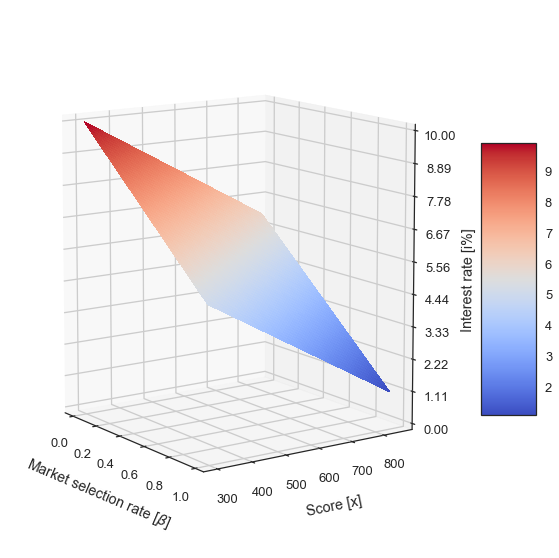

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 1, 0.01)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 5-X*5 + 5-((Y-300)/550)*4 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Market selection rate [$\beta$]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=10., azim=-35)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()